# Import 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import re
import random
import pickle
from glob import glob

# Premiers essais sur les données

In [2]:
# Allure des données générales sur les stations
info=pd.read_json('F:/work/download/stations_info.json')
data_info=pd.DataFrame(info.data.stations)
print('Nombre de stations :',len(data_info))
data_info.head()

Nombre de stations : 1454


,station_id,name,lat,lon,capacity,stationCode,rental_methods
0,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,16107,NaN
1,653222953,Mairie de Rosny-sous-Bois,48.871257,2.486581,30,31104,[CREDITCARD]
2,36255,Toudouze - Clauzel,48.879296,2.337360,21,9020,[CREDITCARD]
3,37815204,Mairie du 12ème,48.840855,2.387555,30,12109,NaN
4,17278902806,Rouget de L'isle - Watteau,48.778193,2.396302,0,44015,NaN


In [131]:
mini=data_info.groupby('stationCode').station_id.count().min()
maxi=data_info.groupby('stationCode').station_id.count().max()
print(mini, maxi)

mini=data_info.groupby('station_id').stationCode.count().min()
maxi=data_info.groupby('station_id').stationCode.count().max()
print(mini, maxi)

#Il y a exactement un station_id par stationCode, et inversement, donc on peut en garder un seul


1 1
1 1


In [128]:
#Allure des données sur les vélos à un temps donné : 
data0=pd.read_json('F:/work/download/stations_status_2023_03_17_16_59_24.json')
data=pd.DataFrame(data0.data.stations)
data.head()

,stationCode,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,is_installed,is_returning,is_renting,last_reported
0,16107,213688169,7,7,"[{'mechanical': 4}, {'ebike': 3}]",28,28,1,1,1,1679066917
1,31104,653222953,8,8,"[{'mechanical': 6}, {'ebike': 2}]",20,20,1,1,1,1679066353
2,9020,36255,2,2,"[{'mechanical': 0}, {'ebike': 2}]",19,19,1,1,1,1679066838
3,12109,37815204,18,18,"[{'mechanical': 16}, {'ebike': 2}]",12,12,1,1,1,1679066819
4,44015,17278902806,0,0,"[{'mechanical': 0}, {'ebike': 0}]",0,0,0,0,0,1675935337


In [4]:
#On vérifie que certaines colonnes sont bien des doublons : 
print( (data.num_bikes_available != data.numBikesAvailable).any() , 
       (data.num_docks_available != data.numDocksAvailable).any() )

False False


In [5]:
# On va garder la version avec des undersocres plutot que des majuscules, vu que les autres champs sont pareils :
data=data.drop(['numBikesAvailable','numDocksAvailable','stationCode'] , axis=1)

In [6]:
data.head()

,stationCode,station_id,num_bikes_available,num_bikes_available_types,num_docks_available,is_installed,is_returning,is_renting,last_reported
0,16107,213688169,7,"[{'mechanical': 4}, {'ebike': 3}]",28,1,1,1,1679066917
1,31104,653222953,8,"[{'mechanical': 6}, {'ebike': 2}]",20,1,1,1,1679066353
2,9020,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838
3,12109,37815204,18,"[{'mechanical': 16}, {'ebike': 2}]",12,1,1,1,1679066819
4,44015,17278902806,0,"[{'mechanical': 0}, {'ebike': 0}]",0,0,0,0,1675935337


# Génération du dataframe

Pour ajouter les données à chaque temps, on va garder la structure des fichiers à un temps donné pour la table totale, mais rajouter un champ 'time' au format datetime. 

Chaque station sera donc présente une fois par temps de mesure, et on pourra extraire ce temps à partir du stationCode ou station_id.

In [248]:
# Fonction pour lire et formater un fichier à partir de son chemin d'accès
def read_data(path_file: str) -> object:
    #Reads the dataframe in the input file
    data0=pd.read_json(path_file)
    data=pd.DataFrame(data0.data.stations)
#     data['num_bikes_available_mech']=data.num_bikes_available_types.apply(lambda x: x[0].get('mechanical'))
#     data['num_bikes_available_elec']=data.num_bikes_available_types.apply(lambda x: x[1].get('ebike'))
    data.insert(3, 'num_bikes_available_mech', 
                     data.num_bikes_available_types.apply(lambda x: x[0].get('mechanical')) )
    data.insert(4, 'num_bikes_available_elec', 
                     data.num_bikes_available_types.apply(lambda x: x[1].get('ebike')) )
    
    #Removes the dupe columns
    data=data.drop(['numBikesAvailable','numDocksAvailable','stationCode','num_bikes_available_types'] , axis=1)
    
    #Determines the time the data was obtained
    date_str=re.search(r"\d{4}(_\d{2}){5}",path_file).group(0)
    date=datetime.datetime.strptime(date_str, '%Y_%m_%d_%H_%M_%S')
    
    #Adds a field for the time
    data['time']=date
    data['weekday']=date.weekday()
    data['hour']=date.time()
    
    return data

In [246]:
# Fonction pour construire le dataframe à partir de tous les fichiers dans le répertoire data_rep
data_rep='F:/work/download/'
def build_df(data_rep: str = data_rep) -> object:
    #Read the list of files in data_rep: 
    list_files=glob(data_rep+'stations_status*.json')
    list_files=list_files
    first=1
    for file in list_files:
        if first :
            df=read_data(file)
            first=0
        else :
            df=pd.concat([df,read_data(file)])
    return df
    

In [249]:
t_ini=time.time()
df=build_df()
t_fin=time.time()
print(f'The dataframe of {df.size} elements was built in {t_fin-t_ini} seconds.')

The dataframe of 32976720 elements was built in 210.48652291297913 seconds.


In [252]:
# with open('F:/work/dataframe.pkl', 'wb') as file:
#     pickle.dump(df, file)

In [201]:
# t_ini=time.time()
# with open('F:/work/dataframe.pkl', 'rb') as file:
#     df=pickle.load(file)
# t_fin=time.time()
# print(t_fin-t_ini)

# Analyse des résultats

## Allure générale

In [251]:
print(f'Dataframe avec {df.size} lignes')
df.describe(include='all')

Dataframe avec 32976720 lignes


C:\Users\Olivier\AppData\Local\Temp\ipykernel_7308\961941925.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour
count,2.748060e+06,2.748060e+06,2732066.0,2732066.0,2.748060e+06,2.748060e+06,2.748060e+06,2.748060e+06,2.748060e+06,2748060,2.748060e+06,2748060
unique,NaN,NaN,69.0,54.0,NaN,NaN,NaN,NaN,NaN,1890,NaN,1890
top,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,2023-03-17 16:30:22,NaN,16:30:22
freq,NaN,NaN,526474.0,404732.0,NaN,NaN,NaN,NaN,NaN,1454,NaN,1454
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-17 16:30:22,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-20 07:59:50,NaN,NaN
mean,1.118766e+09,1.160569e+01,NaN,NaN,1.828188e+01,9.889959e-01,9.748415e-01,9.748415e-01,1.678461e+09,NaN,4.632275e+00,NaN
std,3.235794e+09,1.068412e+01,NaN,NaN,1.213674e+01,1.043218e-01,1.566063e-01,1.566063e-01,8.690929e+06,NaN,1.879355e+00,NaN
min,6.245000e+03,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.520582e+09,NaN,0.000000e+00,NaN
25%,5.592789e+07,4.000000e+00,NaN,NaN,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.679121e+09,NaN,5.000000e+00,NaN


In [11]:
df[df['station_id'] == 36255]

,stationCode,station_id,num_bikes_available,num_bikes_available_types,num_docks_available,is_installed,is_returning,is_renting,last_reported,time
2,9020,36255,4,"[{'mechanical': 1}, {'ebike': 3}]",17,1,1,1,1679066838,2023-03-17 16:30:22
2,9020,36255,5,"[{'mechanical': 1}, {'ebike': 4}]",16,1,1,1,1679066838,2023-03-17 16:34:22
2,9020,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838,2023-03-17 16:57:24
2,9020,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838,2023-03-17 16:59:24
2,9020,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838,2023-03-17 17:01:24
...,...,...,...,...,...,...,...,...,...,...
2,9020,36255,1,"[{'mechanical': 0}, {'ebike': 1}]",20,1,1,1,1679207004,2023-03-19 07:56:08
2,9020,36255,1,"[{'mechanical': 0}, {'ebike': 1}]",20,1,1,1,1679207004,2023-03-19 07:58:09
2,9020,36255,1,"[{'mechanical': 0}, {'ebike': 1}]",20,1,1,1,1679207004,2023-03-19 08:00:10
2,9020,36255,1,"[{'mechanical': 0}, {'ebike': 1}]",20,1,1,1,1679207004,2023-03-19 08:02:09


## Variation au cours du temps

In [12]:
# sns.lineplot(data=df, x='time', y='num_bikes_available', hue='station_id')
#trop lent: je réduis le nombre de stations observées

In [79]:

station_list=list(data_info.station_id)
# station_red=random.sample(station_list,5)
# print(station_red)
station_red=[419991048, 443153677, 129038848, 37879071, 15414455]
df_red=df[df['station_id'].isin(station_red)]

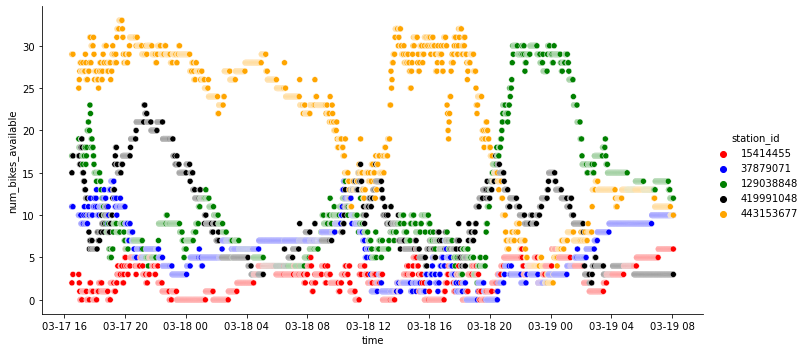

In [36]:
#à noter : lineplot est très lent, et ne renvoie rien même après quelques minutes, mais relplot est quasi instantanné
# sns.lineplot(data=df_red, x='time', y='num_bikes_available', hue='station_id')
sns.relplot(data=df_red, x='time', y='num_bikes_available', hue='station_id', height=5, aspect=2, 
            palette=['red','blue','green', 'black', 'orange'])



Pour ce petit échantillon, on voit bien des oscillations au cours du temps, mais les maximums ne sont pas toujours aux mêmes périodes. Il faudra sans doute séparer les stations par catégorie.

In [ ]:
# sns.lineplot(data=df_red, x='time', y='num_bikes_available', hue='station_id', ci=None, estimator=None)

Seaborn est souvent lent ou peu pratique, donc j'utilise matplotlib par la suite quand c'est possible :

Courbe pour les mêmes stations en matplotlib :

Text(0, 0.5, 'Number of bikes available')

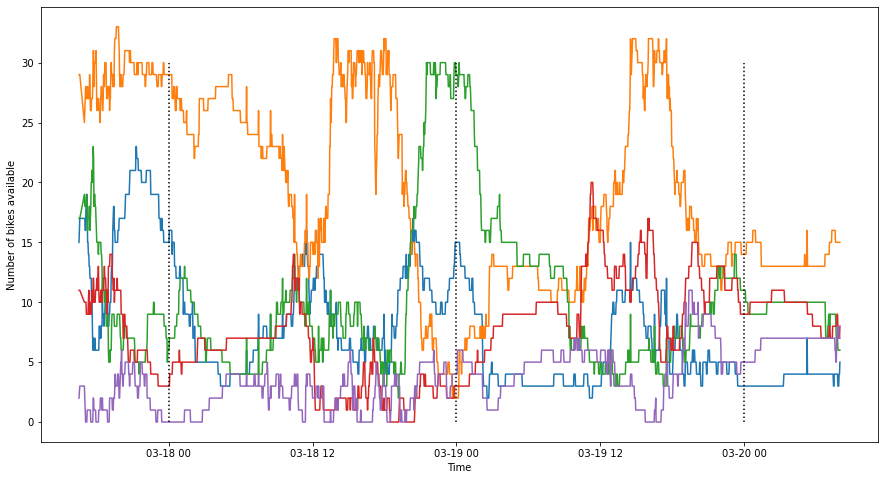

In [85]:
plt.figure(figsize=(15,8))
for i in range(len(station_red)):
               plt.plot('time', 'num_bikes_available', data=df_red[ df_red['station_id'] == station_red[i]])

plt.plot([datetime.datetime(2023,3,18),datetime.datetime(2023,3,18)], [0,30], color='black', linestyle='dotted')
plt.plot([datetime.datetime(2023,3,19),datetime.datetime(2023,3,19)], [0,30], color='black', linestyle='dotted')
plt.plot([datetime.datetime(2023,3,20),datetime.datetime(2023,3,20)], [0,30], color='black', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Number of bikes available')

Courbe pour 20 stations en matplotlib :

Text(0, 0.5, 'Number of bikes available')

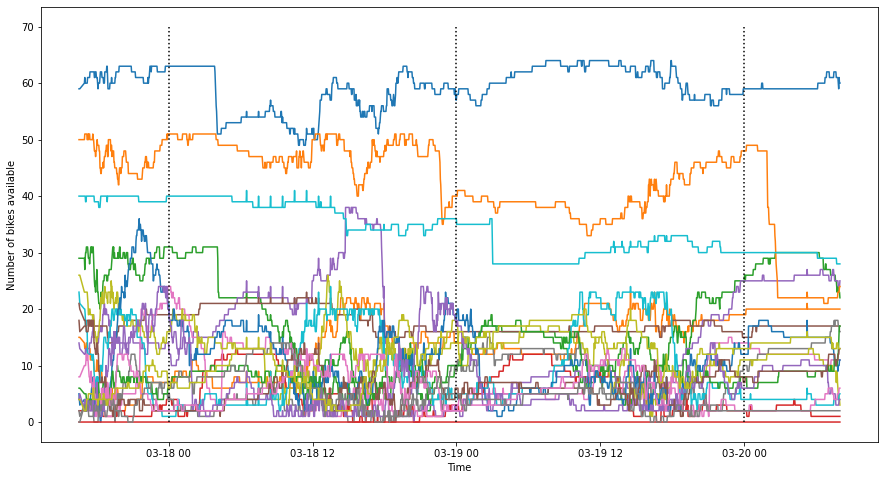

In [88]:
plt.figure(figsize=(15,8))
for station in random.sample(station_list, 20):
               plt.plot('time', 'num_bikes_available', data=df[ df['station_id'] == station])

plt.plot([datetime.datetime(2023,3,18),datetime.datetime(2023,3,18)], [0,70], color='black', linestyle='dotted')
plt.plot([datetime.datetime(2023,3,19),datetime.datetime(2023,3,19)], [0,70], color='black', linestyle='dotted')
plt.plot([datetime.datetime(2023,3,20),datetime.datetime(2023,3,20)], [0,70], color='black', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Number of bikes available')

Quand le nombre de stations augmente, on n'y voit plus rien. Je vais essayer de normaliser les courbes pour voir des tendances :

In [256]:
# station_red=random.sample(station_list, 20)
station_red=[82588494, 82566934, 35137730, 252301607, 210397939, 42603855, 34742973, 
             128890772, 210580039, 349750111, 235241110, 78348185, 54000621, 54000547, 
             303102719, 1055553396, 208795867, 129164969, 82379648, 323468705]

df_red=df[ df['station_id'].isin(station_red)]

Text(0, 0.5, 'Number of bikes available')

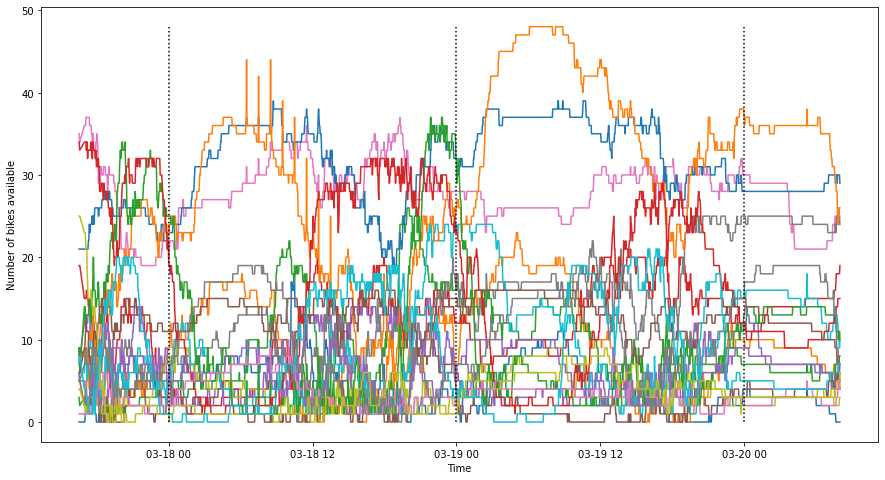

In [114]:
plt.figure(figsize=(15,8))
for station in station_red:
               plt.plot('time', 'num_bikes_available', data=df_red[ df_red['station_id'] == station])

y_day_delim=[0,df_red.num_bikes_available.max()]
x_day_delim1=[datetime.datetime(2023,3,18),datetime.datetime(2023,3,18)]
x_day_delim2=[datetime.datetime(2023,3,19),datetime.datetime(2023,3,19)]
x_day_delim3=[datetime.datetime(2023,3,20),datetime.datetime(2023,3,20)]
plt.plot(x_day_delim1, y_day_delim, color='black', linestyle='dotted')
plt.plot(x_day_delim2, y_day_delim, color='black', linestyle='dotted')
plt.plot(x_day_delim3, y_day_delim, color='black', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Number of bikes available')

Text(0, 0.5, 'Number of bikes available')

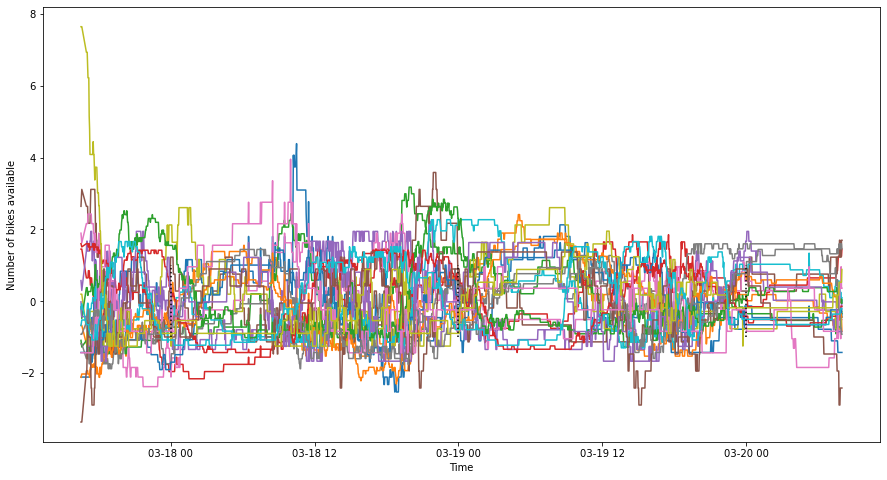

In [119]:
plt.figure(figsize=(15,8))
for station in station_red:
    df_temp=df_red[ df_red['station_id'] == station]
    plt.plot(df_temp.time, 
             (df_temp.num_bikes_available-df_temp.num_bikes_available.mean())/df_temp.num_bikes_available.std())

y_day_delim=[-1,1]
x_day_delim1=[datetime.datetime(2023,3,18),datetime.datetime(2023,3,18)]
x_day_delim2=[datetime.datetime(2023,3,19),datetime.datetime(2023,3,19)]
x_day_delim3=[datetime.datetime(2023,3,20),datetime.datetime(2023,3,20)]
plt.plot(x_day_delim1, y_day_delim, color='black', linestyle='dotted')
plt.plot(x_day_delim2, y_day_delim, color='black', linestyle='dotted')
plt.plot(x_day_delim3, y_day_delim, color='black', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Number of bikes available')

## Stats par station

In [94]:
vec_mean=[]
vec_std=[]
for i in station_list :
    vec_mean.append(df[df['station_id'] == i].num_bikes_available.mean())
    vec_std.append(df[df['station_id'] == i].num_bikes_available.std())
    

Text(0, 0.5, 'Standard deviation')

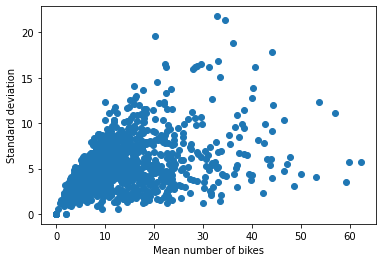

In [121]:
plt.scatter(vec_mean, vec_std)
plt.xlabel('Mean number of bikes')
plt.ylabel('Standard deviation')

## Remarques

Il faudrait rajouter des champs au dataframe ou les modifier: 
 - day_of_week : jour de la semaine, pour traiter différemment selon la semaine travaillée et le week-end
   - ou alors quelque chose comme is_weekend = 0 ou 1
 - hour : heure (en heure:minute) : on tracera les variations sur une journée, donc on veut avoir accès à l'heure directement 
   - il faudrait changer le nom de la colonne 'time' pour éviter les confusions
 - events : facultatif : dire s'il se produit quelquechose comme une grève, ou des vacances
 - remplacer num_bikes_available_types par 2 colonnes num_bikes_available_mech et num_bikes_available_elec, plus facilement accessibles

## Champs isrenting et isreturning

isrenting=1 signifie que la station permet de retirer un vélo.

isreturning=1 signifie que la station permet de déposer un vélo.

On va maintenant regarder comment ces valeurs évoluent.

Stations always renting: 1416, never renting: 36, alternating: 2


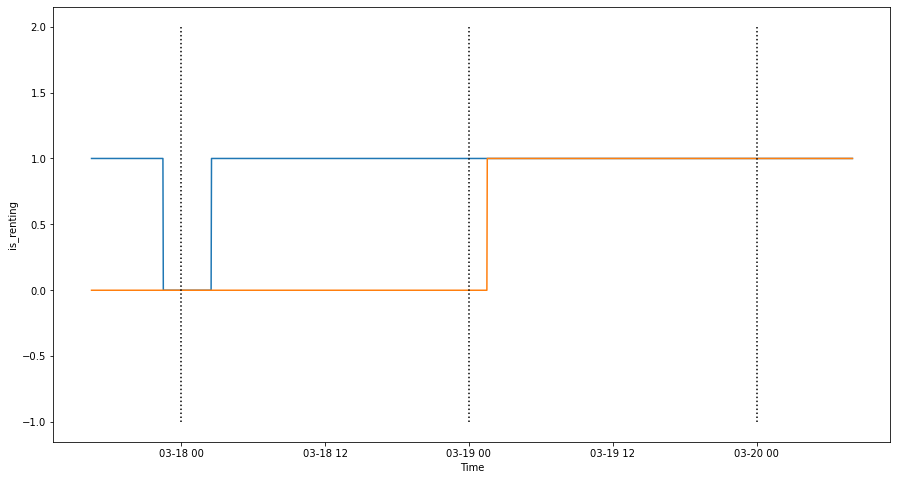

In [272]:
plt.figure(figsize=(15,8))
always_rent=0
never_rent=0
alter_rent=0
for station in station_list:
    df_temp=df[ df['station_id'] == station]
    if df_temp.is_renting.min() == 1 :
        always_rent+=1
    elif df_temp.is_renting.max() == 0 :
        never_rent+=1
    else :
        plt.plot(df_temp.time, df_temp.is_renting)
        alter_rent+=1
        
# for station in station_red:
#     df_temp=df_red[ df_red['station_id'] == station]
#     plt.plot(df_temp.time, df_temp.is_renting)

y_day_delim=[-1,2]
x_day_delim1=[datetime.datetime(2023,3,18),datetime.datetime(2023,3,18)]
x_day_delim2=[datetime.datetime(2023,3,19),datetime.datetime(2023,3,19)]
x_day_delim3=[datetime.datetime(2023,3,20),datetime.datetime(2023,3,20)]
plt.plot(x_day_delim1, y_day_delim, color='black', linestyle='dotted')
plt.plot(x_day_delim2, y_day_delim, color='black', linestyle='dotted')
plt.plot(x_day_delim3, y_day_delim, color='black', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('is_renting')

print(f"Stations always renting: {always_rent}, never renting: {never_rent}, alternating: {alter_rent}")

Stations always returning: 1416, never returning: 36, alternating: 2


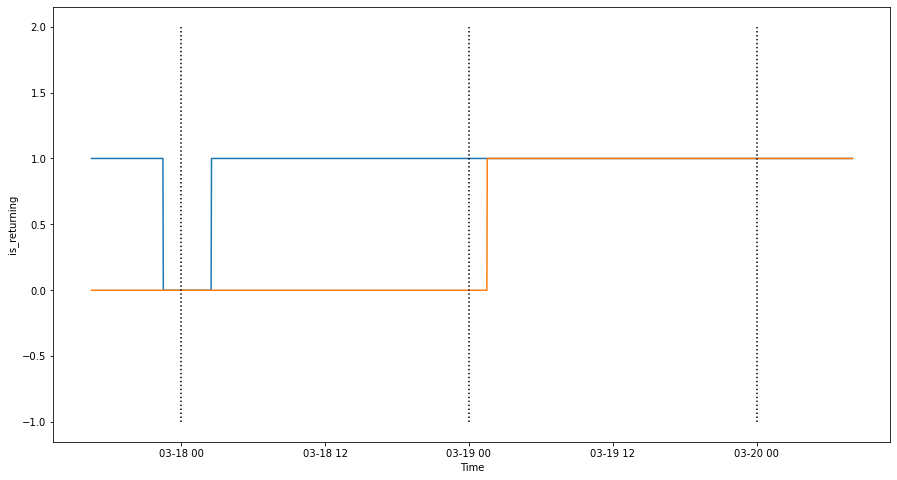

In [273]:
plt.figure(figsize=(15,8))
always_return=0
never_return=0
alter_return=0
for station in station_list:
    df_temp=df[ df['station_id'] == station]
    if df_temp.is_returning.min() == 1 :
        always_return+=1
    elif df_temp.is_returning.max() == 0 :
        never_return+=1
    else :
        plt.plot(df_temp.time, df_temp.is_returning)
        alter_return+=1
        
# for station in station_red:
#     df_temp=df_red[ df_red['station_id'] == station]
#     plt.plot(df_temp.time, df_temp.is_returning)

y_day_delim=[-1,2]
x_day_delim1=[datetime.datetime(2023,3,18),datetime.datetime(2023,3,18)]
x_day_delim2=[datetime.datetime(2023,3,19),datetime.datetime(2023,3,19)]
x_day_delim3=[datetime.datetime(2023,3,20),datetime.datetime(2023,3,20)]
plt.plot(x_day_delim1, y_day_delim, color='black', linestyle='dotted')
plt.plot(x_day_delim2, y_day_delim, color='black', linestyle='dotted')
plt.plot(x_day_delim3, y_day_delim, color='black', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('is_returning')

print(f"Stations always returning: {always_return}, never returning: {never_return}, alternating: {alter_return}")

is_renting est visiblement toujours égal à is_returning